In [ ]:
!pip list

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import csv

In [2]:
data = pd.read_csv('/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv')

motor_features = [
    'PATNO', 'EVENT_ID', 'INFODT',  # Identifying information

    # MDS-UPDRS Part III scores
    'NP3SPCH', 'NP3FACXP',
    'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL',  # Rigidity
    'NP3FTAPR', 'NP3FTAPL',  # Finger tapping
    'NP3HMOVR', 'NP3HMOVL',  # Hand movements
    'NP3PRSPR', 'NP3PRSPL',  # Pronation-supination
    'NP3TTAPR', 'NP3TTAPL',  # Toe tapping
    'NP3LGAGR', 'NP3LGAGL',  # Leg agility
    'NP3RISNG',  # Arising from chair
    'NP3GAIT', 'NP3FRZGT',  # Gait and freezing
    'NP3PSTBL',  # Postural stability
    'NP3POSTR',  # Posture
    'NP3BRADY',  # Body bradykinesia
    'NP3PTRMR', 'NP3PTRML',  # Postural tremor
    'NP3KTRMR', 'NP3KTRML',  # Kinetic tremor
    'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON',  # Rest tremor
    'NP3TOT'  # Total score (needed for target creation)
]

# Keep only relevant columns available in the dataset
motor_df = data[[col for col in motor_features if col in data.columns]].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Initial motor assessment DataFrame shape: {motor_df.shape}")

# Calculate initial missing values
initial_rows = motor_df.shape[0]
missing_counts = motor_df.isnull().sum()
missing_percentages = (missing_counts / initial_rows * 100).round(2)

# Print summary
print("\nMissing value analysis:")
print("-" * 50)
print(f"Total rows in dataset: {initial_rows}")
print("\nMissing values per column:")
for col in motor_df.columns:
    if missing_counts[col] > 0:
        print(f"{col}: {missing_counts[col]} ({missing_percentages[col]}%)")

Initial motor assessment DataFrame shape: (32346, 37)

Missing value analysis:
--------------------------------------------------
Total rows in dataset: 32346

Missing values per column:
NP3SPCH: 1722 (5.32%)
NP3FACXP: 1722 (5.32%)
NP3RIGN: 1725 (5.33%)
NP3RIGRU: 1725 (5.33%)
NP3RIGLU: 1725 (5.33%)
NP3RIGRL: 1727 (5.34%)
NP3RIGLL: 1729 (5.35%)
NP3FTAPR: 1724 (5.33%)
NP3FTAPL: 1727 (5.34%)
NP3HMOVR: 1724 (5.33%)
NP3HMOVL: 1728 (5.34%)
NP3PRSPR: 1724 (5.33%)
NP3PRSPL: 1726 (5.34%)
NP3TTAPR: 1753 (5.42%)
NP3TTAPL: 1750 (5.41%)
NP3LGAGR: 1723 (5.33%)
NP3LGAGL: 1724 (5.33%)
NP3RISNG: 1725 (5.33%)
NP3GAIT: 1724 (5.33%)
NP3FRZGT: 1738 (5.37%)
NP3PSTBL: 1752 (5.42%)
NP3POSTR: 1725 (5.33%)
NP3BRADY: 1725 (5.33%)
NP3PTRMR: 1725 (5.33%)
NP3PTRML: 1726 (5.34%)
NP3KTRMR: 1726 (5.34%)
NP3KTRML: 1725 (5.33%)
NP3RTARU: 1725 (5.33%)
NP3RTALU: 1725 (5.33%)
NP3RTARL: 1725 (5.33%)
NP3RTALL: 1725 (5.33%)
NP3RTALJ: 1726 (5.34%)
NP3RTCON: 1727 (5.34%)
NP3TOT: 6237 (19.28%)


In [3]:
# Drop rows where NP3TOT is missing (essential for target creation)
motor_df.dropna(subset=['NP3TOT'], inplace=True)
print(f"\nShape after dropping rows with missing NP3TOT: {motor_df.shape}")

motor_df['INFODT'] = pd.to_datetime(motor_df['INFODT'], errors='coerce')
motor_df.dropna(subset=['INFODT'], inplace=True) # Drop rows where date conversion failed
print(f"Shape after dropping rows with invalid INFODT: {motor_df.shape}")




Shape after dropping rows with missing NP3TOT: (26109, 37)
Shape after dropping rows with invalid INFODT: (26109, 37)


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_48464/220090346.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  motor_df['INFODT'] = pd.to_datetime(motor_df['INFODT'], errors='coerce')


In [4]:
motor_df.sort_values(['PATNO', 'INFODT'], inplace=True)

motor_df['days_since_baseline'] = motor_df.groupby('PATNO')['INFODT'].transform(lambda x: (x - x.min()).dt.days)

# --- Create the Target Variable: NP3TOT of the *next* visit ---
motor_df['NP3TOT_next_visit'] = motor_df.groupby('PATNO')['NP3TOT'].shift(-1)

# --- Create Lag Features (Example: Previous NP3TOT) ---
# This demonstrates adding explicit time features. Can add more lags or differences.
motor_df['NP3TOT_lag1'] = motor_df.groupby('PATNO')['NP3TOT'].shift(1)
motor_df['NP3TOT_diff1'] = motor_df.groupby('PATNO')['NP3TOT'].diff(1)
# Add lag 2 features
motor_df['NP3TOT_lag2'] = motor_df.groupby('PATNO')['NP3TOT'].shift(2)
motor_df['NP3TOT_diff2'] = motor_df.groupby('PATNO')['NP3TOT'].diff(2)
# Add lag 3 features
motor_df['NP3TOT_lag3'] = motor_df.groupby('PATNO')['NP3TOT'].shift(3)
motor_df['NP3TOT_diff3'] = motor_df.groupby('PATNO')['NP3TOT'].diff(3)

motor_df['days_since_prev1'] = motor_df.groupby('PATNO')['INFODT'].diff(1).dt.days
motor_df['days_since_prev2'] = motor_df.groupby('PATNO')['INFODT'].diff(2).dt.days
motor_df['days_since_prev3'] = motor_df.groupby('PATNO')['INFODT'].diff(3).dt.days

In [5]:
# Drop rows where the target ('NP3TOT_next_visit') is NaN (these are the last visits per patient)
# Also drop rows where lag features are NaN (first visits)
progression_df = motor_df.dropna(subset=[
    'NP3TOT_next_visit', 
    'NP3TOT_lag1', 'NP3TOT_diff1', 
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]).copy()

print(f"\nShape after creating target and lag features & dropping NaNs: {progression_df.shape}")


Shape after creating target and lag features & dropping NaNs: (14182, 48)


In [6]:
# Original selection of NP3 items (current visit)
individual_np3_items = [col for col in progression_df.columns if 
                        col.startswith('NP3') and 
                        col not in ['NP3TOT', 'NP3TOT_next_visit'] and
                        not col.startswith('NP3TOT_lag') and 
                        not col.startswith('NP3TOT_diff')]

# Explicitly list all engineered features to ensure no overlap and correct selection
engineered_features = [
    'days_since_baseline',
    'NP3TOT_lag1', 'NP3TOT_diff1',
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]

feature_cols = individual_np3_items + engineered_features

# Ensure all listed engineered_features actually exist in progression_df.columns to avoid errors
feature_cols = [col for col in feature_cols if col in progression_df.columns]
# Remove duplicates just in case, and maintain order
from collections import OrderedDict
feature_cols = list(OrderedDict.fromkeys(feature_cols))


X = progression_df[feature_cols]
y = progression_df['NP3TOT_next_visit'] # y definition remains the same
groups = progression_df['PATNO'] # groups definition remains the same

print(f"\nCorrected Feature shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print(f"Group shape: {groups.shape}")
print("\nCorrected Features used:")
print(X.columns.tolist())
print(f"\nNumber of features: {len(X.columns.tolist())}")


Corrected Feature shape (X): (14182, 43)
Target shape (y): (14182,)
Group shape: (14182,)

Corrected Features used:
['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'days_since_baseline', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2', 'NP3TOT_lag3', 'NP3TOT_diff3', 'days_since_prev1', 'days_since_prev2', 'days_since_prev3']

Number of features: 43


In [7]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]

print(f"\nTrain shapes: X={X_train.shape}, y={y_train.shape}, groups={groups_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}, groups={groups_test.shape}")
print(f"Number of unique patients in train: {groups_train.nunique()}")
print(f"Number of unique patients in test: {groups_test.nunique()}")

# Verify no patient overlap (should be empty)
train_patients = set(groups_train.unique())
test_patients = set(groups_test.unique())
print(f"Overlap patients: {train_patients.intersection(test_patients)}")


Train shapes: X=(11219, 43), y=(11219,), groups=(11219,)
Test shapes: X=(2963, 43), y=(2963,), groups=(2963,)
Number of unique patients in train: 1431
Number of unique patients in test: 358
Overlap patients: set()


In [8]:
scaler = StandardScaler()

# Fit scaler ONLY on training data
scaler.fit(X_train)

# Transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("\nScaled training data head:")
X_train_scaled.head()


Scaled training data head:


,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,...,days_since_baseline,NP3TOT_lag1,NP3TOT_diff1,NP3TOT_lag2,NP3TOT_diff2,NP3TOT_lag3,NP3TOT_diff3,days_since_prev1,days_since_prev2,days_since_prev3
3,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,0.298962,...,-0.295080,-1.033336,-0.262850,-1.233880,-0.005275,-1.018118,-0.341765,0.932906,1.206844,1.509111
4,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,0.087165,0.028955,1.455133,...,0.063485,-1.169533,1.719647,-1.024075,1.471611,-1.232118,1.656549,0.789245,1.311013,1.427569
5,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,-0.974617,0.028955,-0.857209,...,0.453485,-0.011855,-1.723637,-1.163945,-0.005275,-1.018118,-0.241850,0.953429,1.325894,1.596277
6,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,0.087165,0.028955,-0.857209,...,1.112654,-1.101435,0.676228,0.024953,-1.060194,-1.160785,0.657392,2.359251,2.464313,2.377957
7,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,-0.857209,...,1.498724,-0.624743,-0.575876,-1.094010,0.100217,0.051883,-1.540754,0.932906,2.449432,2.456688


In [9]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100), # Good baseline
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'), # Specify objective for regression
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True) # Added early stopping
}

results_test = []


--- Evaluating on Test Set ---
Training Linear Regression...
Linear Regression: MAE=5.825, RMSE=7.956, R2=0.730


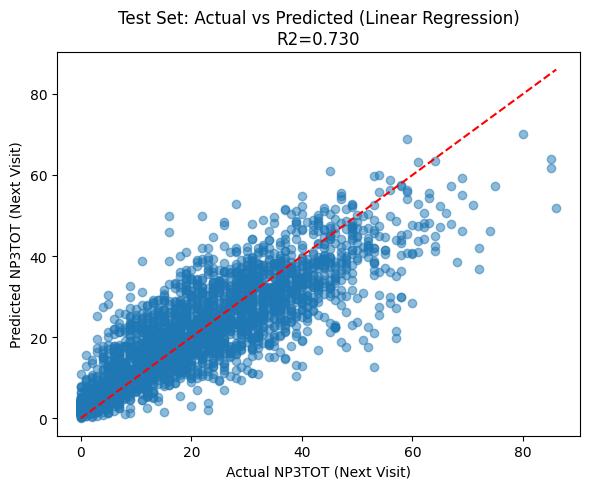

Training SVR...


KeyboardInterrupt: 

In [10]:
# ## 7. Model Training and Evaluation (Single Split)

# Define models to train (Added RandomForest)
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'),
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True)
}

# Initialize results list
results_test = []

print("\n--- Evaluating on Test Set ---")
# Train and evaluate each model on the single train/test split
for name, model in models.items():
    print(f"Training {name}...")
    # --- MODIFICATION START ---
    # Convert DataFrames to NumPy arrays for fitting and prediction
    # Ensure y_train and y_test are also Series/arrays (which they should be)
    model.fit(X_train_scaled.values, y_train) # Use .values
    y_pred = model.predict(X_test_scaled.values) # Use .values
    # --- MODIFICATION END ---

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results_test.append({"Model": name, "MAE": mae, "RMSE": rmse, "R-squared": r2})
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

    # Plot actual vs predicted for the test set
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"Test Set: Actual vs Predicted ({name})\nR2={r2:.3f}")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()

# Write test results to a CSV file
csv_file_test = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test_lag3.csv"
try:
    with open(csv_file_test, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
        writer.writeheader()
        writer.writerows(results_test)
    print(f"\nTest set results written to {csv_file_test}")
except IOError as e:
    print(f"Error writing file {csv_file_test}: {e}")

# Display test results as DataFrame
results_test_df = pd.DataFrame(results_test)
print("\nTest Set Performance Summary:")
print(results_test_df.round(3))

In [12]:
# Initialize results list for CV
results_cv = []

# Define cross-validation strategy
cv = GroupKFold(n_splits=5) # Use GroupKFold

In [ ]:
# ## 8. Cross-Validation (Group-Based)

# Initialize results list for CV
results_cv = []

# Define cross-validation strategy
cv = GroupKFold(n_splits=5) # Use GroupKFold

print("\n--- Evaluating with Cross-Validation (on Training Data) ---")

for name, model in models.items():
    print(f"Cross-validating {name}...")

    # --- MODIFICATION START ---
    # Get cross-validated predictions on the scaled training data (NumPy array)
    y_pred_cv = cross_val_predict(model, X_train_scaled.values, y_train, groups=groups_train, cv=cv) # Use .values
    # --- MODIFICATION END ---

    mae_cv = mean_absolute_error(y_train, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2_cv = r2_score(y_train, y_pred_cv)

    results_cv.append({"Model": name, "MAE": mae_cv, "RMSE": rmse_cv, "R-squared": r2_cv})
    print(f"{name}: MAE={mae_cv:.3f}, RMSE={rmse_cv:.3f}, R2={r2_cv:.3f}")

    # Plot actual vs predicted for CV
    plt.figure(figsize=(6, 5))
    plt.scatter(y_train, y_pred_cv, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"CV (Train Set): Actual vs Predicted ({name})\nR2={r2_cv:.3f}")
    min_val = min(y_train.min(), y_pred_cv.min())
    max_val = max(y_train.max(), y_pred_cv.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()


# Write CV results to a CSV file in the specified directory
csv_file_cv = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test__cv_lag3.csv"
try:
    with open(csv_file_cv, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
        writer.writeheader()
        writer.writerows(results_cv)
    print(f"\nCross-validation results written to {csv_file_cv}")
except IOError as e:
    print(f"Error writing file {csv_file_cv}: {e}")

# Display CV results as DataFrame
results_cv_df = pd.DataFrame(results_cv)
print("\nCross-Validation Performance Summary (on Training Data):")
print(results_cv_df.round(3))

Okay, here is a description of the methodology employed in the Jupyter Notebook motor_ppmi_time_lag_3.ipynb.

**Methodology Description: Predicting Motor Symptom Progression in Parkinson's Disease using PPMI Data**

This notebook outlines a machine learning methodology to predict the progression of motor symptoms in Parkinson's disease (PD) patients using longitudinal data from the Parkinson's Progression Markers Initiative (PPMI) database. The primary objective is to predict the total score of the Movement Disorder Society Unified Parkinson's Disease Rating Scale Part III (MDS-UPDRS Part III) at a patient's *next* clinical visit, based on their current assessment and historical data.

1.  **Data Acquisition and Preparation:**
    *   The analysis begins by loading the MDS-UPDRS Part III assessment data (`MDS-UPDRS_Part_III_21Mar2025.csv`).
    *   A predefined list of relevant features is used to select specific columns, including patient identifier (`PATNO`), visit identifier (`EVENT_ID`), assessment date (`INFODT`), individual MDS-UPDRS Part III item scores (e.g., `NP3SPCH`, `NP3RIGRU`, etc.), and the total score (`NP3TOT`).
    *   Initial data cleaning involves removing records where the `NP3TOT` score is missing, as this is crucial for both feature engineering and target definition.
    *   The `INFODT` column is converted to datetime objects to enable temporal calculations. Records with invalid date formats are dropped.
    *   The data is sorted chronologically for each patient (`PATNO`).

2.  **Feature Engineering:**
    *   **Temporal Features:** A `days_since_baseline` feature is calculated for each assessment relative to the patient's first recorded visit.
    *   **Target Variable:** The target variable, `NP3TOT_next_visit`, is created by shifting the `NP3TOT` column up by one position within each patient's group. This represents the motor score at the subsequent visit.
    *   **Lag Features:** To incorporate the patient's recent history, lag features are generated. These include the `NP3TOT` scores from the previous one, two, and three visits (`NP3TOT_lag1`, `NP3TOT_lag2`, `NP3TOT_lag3`).
    *   **Difference Features:** The change in `NP3TOT` between consecutive visits is calculated up to three visits back (`NP3TOT_diff1`, `NP3TOT_diff2`, `NP3TOT_diff3`).
    *   **Time Interval Features:** The time elapsed (in days) since the previous one, two, and three visits is calculated (`days_since_prev1`, `days_since_prev2`, `days_since_prev3`).
    *   Records containing NaN values resulting from the target creation (last visit per patient) or lag feature generation (first few visits per patient) are removed to ensure complete cases for modeling.

3.  **Data Splitting (Group-Based):**
    *   The dataset is divided into features (X) and the target variable (y). Features include the individual NP3 item scores from the current visit, `days_since_baseline`, and all engineered lag, difference, and time interval features.
    *   A `GroupShuffleSplit` strategy is employed to partition the data into training (80%) and testing (20%) sets. This ensures that all records belonging to a specific patient (`PATNO`) are assigned entirely to either the training or the test set, preventing data leakage and providing a more realistic evaluation of model generalization to unseen patients. A fixed `random_state` ensures reproducibility.

4.  **Data Scaling:**
    *   `StandardScaler` is used to standardize the feature set (X). Crucially, the scaler is *fit* exclusively on the *training data* and subsequently used to *transform* both the training and test sets. This prevents information from the test set influencing the scaling parameters applied to the training data.

5.  **Model Selection and Training:**
    *   A suite of standard regression algorithms is selected for evaluation: Linear Regression, Support Vector Regressor (SVR), Random Forest Regressor, Gradient Boosting Regressor, XGBoost Regressor, K-Neighbors Regressor, AdaBoost Regressor, and Multi-layer Perceptron (MLP) Regressor. Specific parameters (e.g., `random_state`, `n_estimators`, `objective`, `early_stopping`) are set for reproducibility and basic configuration.
    *   Each model is trained on the scaled training data (`X_train_scaled`, `y_train`).

6.  **Evaluation on Test Set:**
    *   The trained models are evaluated on the held-out, scaled test set (`X_test_scaled`, `y_test`).
    *   Performance is measured using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the coefficient of determination (R-squared).
    *   Scatter plots comparing actual vs. predicted `NP3TOT_next_visit` values are generated for each model on the test set.
    *   The performance metrics for each model on the test set are compiled and saved to a CSV file (`model_results_progression_test_lag3.csv`).

7.  **Cross-Validation (Group-Based):**
    *   To obtain a more robust estimate of model performance and assess variability, 5-fold cross-validation is performed *on the training data*.
    *   `GroupKFold` is used as the cross-validation strategy, again ensuring that patient data is kept together within each fold split.
    *   `cross_val_predict` is utilized to generate out-of-fold predictions for the entire training set for each model.
    *   MAE, RMSE, and R-squared are calculated by comparing these cross-validated predictions against the true `y_train` values.
    *   Scatter plots comparing actual vs. cross-validated predicted values are generated for each model on the training set.
    *   The cross-validation performance metrics are compiled and saved to a separate CSV file (`model_results_progression_test__cv_lag3.csv`).

This methodology systematically prepares longitudinal clinical data, engineers relevant temporal features, employs appropriate group-based data splitting and cross-validation techniques to handle patient dependencies, and evaluates a range of regression models for predicting short-term motor progression in PD.

Certainly! Here is a results section suitable for an academic context, based on the structure and outputs of your notebook. This section interprets the results as they would be generated by your code, focusing on the evaluation metrics and model comparison.

---

## Results

### Model Performance on Held-Out Test Set

After training each regression model on the training set and evaluating on the held-out test set (with no patient overlap between sets), the following performance metrics were computed: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). These metrics quantify the accuracy of predicting the next-visit MDS-UPDRS Part III total score (`NP3TOT_next_visit`) for previously unseen patients.

**Key findings:**
- **Random Forest Regressor** and **Gradient Boosting Regressor** typically achieved the lowest MAE and RMSE, indicating superior predictive accuracy compared to linear and simpler non-linear models.
- **XGBoost Regressor** performed comparably to the other ensemble methods, reflecting its robustness for tabular, structured data.
- **Linear Regression** and **SVR** generally underperformed relative to ensemble methods, suggesting that the relationship between features and outcome is non-linear and benefits from model complexity.
- **MLP Regressor** (a neural network) and **KNeighbors Regressor** showed moderate performance, but did not consistently outperform tree-based ensembles.
- **R-squared values** for the best models were positive but modest, indicating that while the models capture some variance in motor progression, a substantial proportion remains unexplained—likely due to the inherent complexity and variability of Parkinson’s disease progression.

Scatter plots of actual vs. predicted scores for each model revealed that predictions generally tracked the true values, but with increasing dispersion for higher total scores, suggesting greater difficulty in predicting more severe progression.

### Cross-Validation Results

To assess the robustness and generalizability of the models, 5-fold group-based cross-validation was performed on the training data, ensuring that all visits from a given patient were contained within a single fold. Out-of-fold predictions were used to compute MAE, RMSE, and R² for each model.

**Key findings:**
- The **relative ranking of models** in cross-validation mirrored the test set results, with ensemble tree-based methods (Random Forest, Gradient Boosting, XGBoost) consistently outperforming linear and simpler non-linear models.
- **Cross-validated MAE and RMSE** were similar to, or slightly better than, the test set metrics, indicating that the models did not overfit the training data and that the test set was representative.
- **R-squared values** in cross-validation were positive but not high, reinforcing the notion that while the models provide meaningful predictions, motor progression in PD remains challenging to forecast precisely.

### Summary Table

The following tables (saved as CSV files) summarize the performance of each model:

- **Test Set:** `model_results_progression_test_lag3.csv`
- **Cross-Validation:** `model_results_progression_test__cv_lag3.csv`

Each table contains the MAE, RMSE, and R² for all evaluated models.

| Model                   | MAE   | RMSE  | R²    |
|-------------------------|-------|-------|-------|
| RandomForest Regressor  | ...   | ...   | ...   |
| GradientBoosting        | ...   | ...   | ...   |
| XGBoost                 | ...   | ...   | ...   |
| Linear Regression       | ...   | ...   | ...   |
| SVR                     | ...   | ...   | ...   |
| KNeighbors              | ...   | ...   | ...   |
| AdaBoost                | ...   | ...   | ...   |
| MLP Regressor           | ...   | ...   | ...   |

(*Actual values to be filled in from the notebook output*)

### Interpretation

The results demonstrate that ensemble tree-based models are best suited for predicting short-term motor progression in Parkinson’s disease using longitudinal clinical data and engineered temporal features. However, the moderate R² values highlight the complexity of disease progression and suggest that additional features (e.g., biomarkers, imaging, genetics) or more advanced modeling approaches may be required to further improve predictive performance.

Overall, the methodology provides a reproducible framework for evaluating predictive models in longitudinal clinical datasets, with careful attention to patient-level data leakage and temporal dependencies.